# FINAL PROJECT

#### The data challenge is available: https://www.kaggle.com/competitions/instacart-market-basket-analysis
#### My GitHub is available: : https://github.com/lzheng01/Instacart-Market-Basket-Analysis

The data challenge is sponsored by Instacart. It challenges the Kaggle community to use the anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, there is between 4 and 100 of their orders, with the sequence of products purchased in each order. It also provide the week and hour of day the order was placed, and a relative measure of time between orders.

The project is to build a recommender system for users to predict the next customer purchase using unsupervised machine learning algorithms.

In [1]:
!pip install memory_profiler

In [2]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from google.colab import drive
import time
from memory_profiler import memory_usage

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Setup my google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read in the datasets
aisles      = pd.read_csv("/content/drive/My Drive/5510/aisles.csv")
departments = pd.read_csv("/content/drive/My Drive/5510/departments.csv")
order_products_prior = pd.read_csv("/content/drive/My Drive/5510/order_products__prior.csv")
order_products_train = pd.read_csv("/content/drive/My Drive/5510/order_products__train.csv")
orders   = pd.read_csv("/content/drive/My Drive/5510/orders.csv")
products = pd.read_csv("/content/drive/My Drive/5510/products.csv")

## 1. Exploratory Analysis (EDA)

### 1.1 Review Individual Dataset

In [10]:
# Print out the first few records of each dataset
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [12]:
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [14]:
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [15]:
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [16]:
#Check the properties of each dataset
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [17]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [18]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [20]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [21]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [22]:
# Check unique values for 'eval_set'
orders['eval_set'].unique()

array(['prior', 'train', 'test'], dtype=object)

In [23]:
prior_num = len(orders[orders['eval_set'] == 'prior'])
train_num = len(orders[orders['eval_set'] == 'train'])
test_num = len(orders[orders['eval_set'] == 'test'])
print(f'Orders data has {prior_num} prior data, {train_num} train data, and {test_num} test data.')

Orders data has 3214874 prior data, 131209 train data, and 75000 test data.


After the overview of all the 5 data file, here is the variable descriptions.

| Variable Name            | Description                                                                                                              |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------|
| **order_id**             | A unique ID for each order.                                                                                              |
| **user_id**              | A unique ID of the user.                                                                                                 |
| **eval_set**             | Specifies the type of the dataset, which can be "prior", "train", or "test".                                             |
| **prior**                | Represents past orders of users; part of the dataset used for understanding historical data.                             |
| **train**                | Represents the training dataset where the model learns; used during the training phase.                                 |
| **test**                 | Represents the test dataset used to evaluate the model's performance and make predictions on unseen data.               |
| **order_number**         | Indicates the sequence number of the user’s order.                                                                      |
| **order_dow**            | Day of the week the order was made, represented as a number from 0 (Sunday) to 6 (Saturday).                            |
| **order_hour_of_day**    | The hour of the day the order was made, represented as a number from 0 to 23.                                           |
| **days_since_prior_order** | Number of days between this order and the previous order; NaN if it's the user's first order.                          |

In [24]:
# Check for NUll value in orders
orders.isnull().sum()

,0
order_id,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,206209


In [25]:
# Check for duplicated values
orders.duplicated().sum()

0

The orders dataset will be the main source to build up the recommender system. Therefore, I checked the missing value and duplicates in the dataset. It only has null values in the 'days_since_prior_order' variable, which is reasonable. When it is the first order, the information of the previous order is not applicable. Also, no duplicates are detected in the dataset. Overall, it is a clean dataset and can be processed without further data cleaning steps.

## 1.2 Combine Datasets

In [5]:
# Merge order (Prior subset) and order_products data into one dataframe
orders_prior = orders[orders['eval_set'] == 'prior']
df_order = pd.merge(order_products_prior, orders_prior, how='inner', on='order_id')
df_order.head(5)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [27]:
# Merge products, aisles and departments data into one dataframe
products = pd.merge(products, aisles, how='left', on='aisle_id')
products = pd.merge(products, departments, how='left', on='department_id')
products.head(5)

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


## 1.3 Data Exploration

In [28]:
# Count the frequency of each product ID in the DataFrame
count_pr = df_order['product_id'].value_counts()
count_pr = count_pr.reset_index()
count_pr.columns = ['product_id', 'count']
count_pr = pd.merge(count_pr, products, how='left', on='product_id')[[ 'product_name', 'product_id', 'count', 'department', 'aisle']]

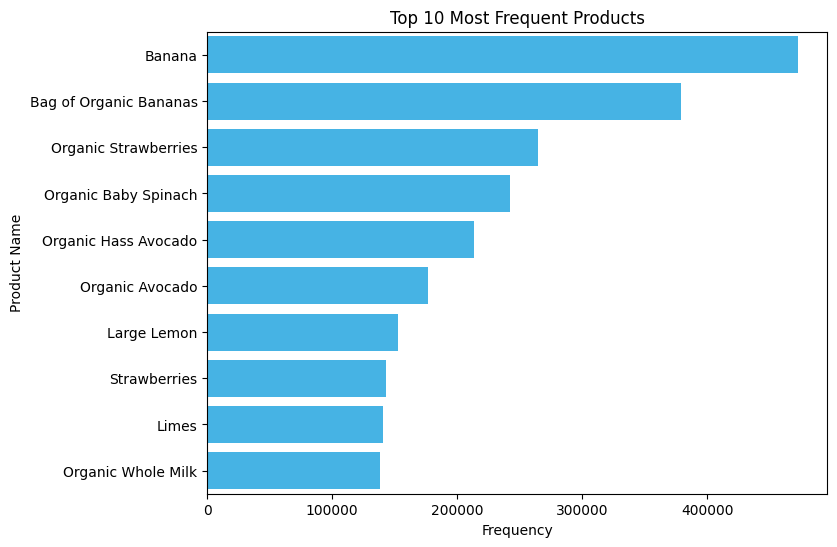

In [29]:
# Plot 10 most frequent products
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='product_name', data=count_pr.head(10), color='#2CBDFE')
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Frequency')
plt.ylabel('Product Name')
plt.show()

The top 10 most frequent products are most fruits and vegetables. Let's check whether there is any difference when analyze by departments and aisles.

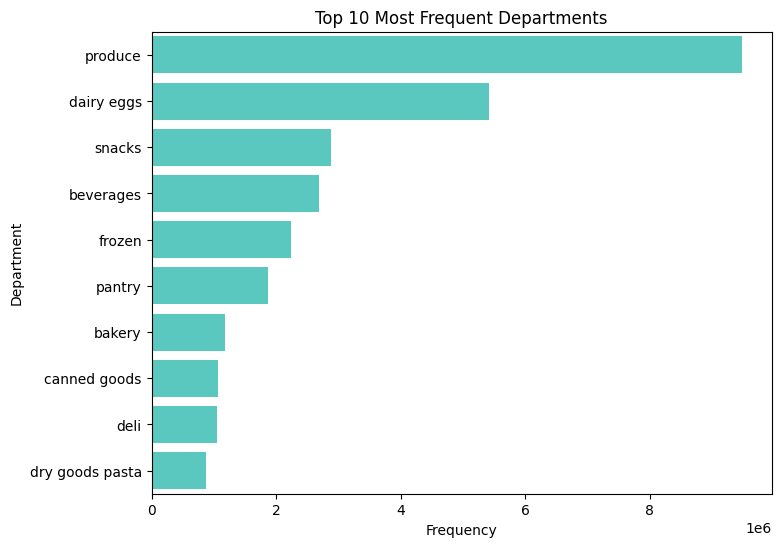

In [30]:
# Plot 10 most frequent departments
count_dp = count_pr.groupby('department')['count'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='department', data=count_dp.head(10), color='#47DBCD')
plt.title('Top 10 Most Frequent Departments')
plt.xlabel('Frequency')
plt.ylabel('Department')
plt.show()

The majority of the products are from produce and dairy eggs departments. The sum of frequencies in these two departments weights more than half of the total dataset.

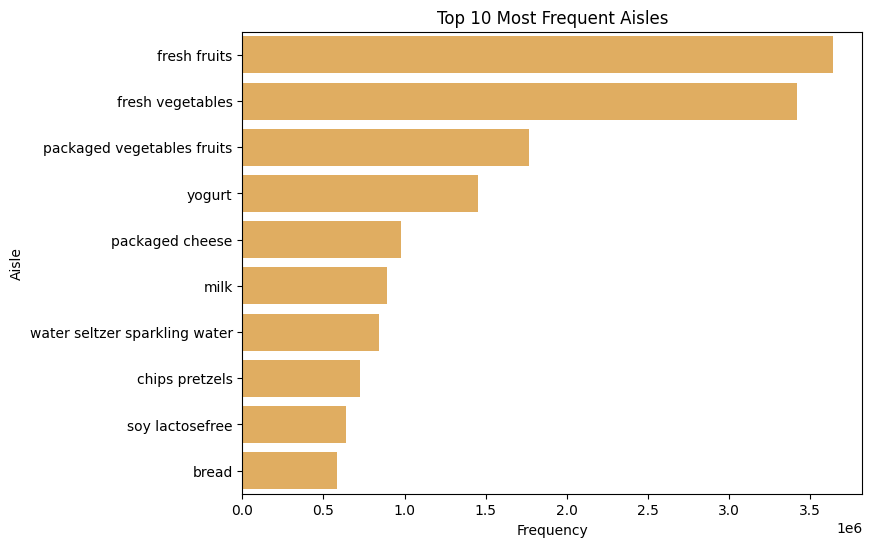

In [31]:
# Plot 10 most frequent aisles
count_al = count_pr.groupby('aisle')['count'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='aisle', data=count_al.head(10), color='#F5B14C')
plt.title('Top 10 Most Frequent Aisles')
plt.xlabel('Frequency')
plt.ylabel('Aisle')
plt.show()

Fresh fruits and vegetables are the most frequent aisles with very large amounts values compared with others.

It tells that the dataset may not be balanced, and it may impact the training of unsupervised machine learning algorithms.

-------
# 2. Model Building and Training
-----



In [6]:
df_order = df_order.drop(['eval_set', 'add_to_cart_order', 'reordered', 'order_number'], axis=1)

#Derive a new varaible "day_hour" which combines the values of "order_dow" (day of the week) and "order_hour_of_day"(hour of the day) columns.
df_order["day_hour"] = [f"{day}-{hour}" for day,hour in zip(df_order["order_dow"],df_order["order_hour_of_day"])]
df_order.head(5)

,order_id,product_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,day_hour
0,2,33120,202279,5,9,8.0,5-9
1,2,28985,202279,5,9,8.0,5-9
2,2,9327,202279,5,9,8.0,5-9
3,2,45918,202279,5,9,8.0,5-9
4,2,30035,202279,5,9,8.0,5-9


In [7]:
# Select the records which fall in the 95% confidence interval of the most frequent product
low_conf, up_conf = sms.DescrStatsW(df_order["product_id"].value_counts()).tconfint_mean()
important_products = df_order["product_id"].value_counts()[df_order["product_id"].value_counts() > low_conf].index
df_order = df_order[df_order["product_id"].isin(important_products)]

In [8]:
# Select the records which fall in the 95% confidence interval of the most loyalful customer
df_order["user_id"].value_counts()
low_conf, up_conf = sms.DescrStatsW(df_order["user_id"].value_counts()).tconfint_mean()
important_baskets = df_order["user_id"].value_counts()[df_order["user_id"].value_counts() > low_conf].index
df_order = df_order[df_order["user_id"].isin(important_baskets)]

## 2.1 Apriori Algorithm

Apriori algorithm is an unsupervised machine learning algorithm used for association rule learning. Association rule learning is a data mining technique that identifies frequent patterns, connections and dependencies among different groups of items called itemsets in data.Some common use cases are disease prediction and recommendation systems like market basket analysis for ecommerce platforms.

In [13]:
# Conduct the user-product matrix
df_most = df_order.groupby(["user_id","product_id"])["order_id"].count().unstack().notnull()
df_most.head(5)

product_id,1,10,23,25,28,34,37,45,49,54,...,49615,49621,49628,49640,49644,49652,49655,49667,49680,49683
user_id,,,,,,,,,,,,,,,,,,,,,
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# Generate frequent_itemsets
frequent_itemsets = apriori(df_most, min_support=0.1, use_colnames=True, verbose=1)
frequent_itemsets.sort_values("support", ascending=False)
frequent_itemsets

Processing 580 combinations | Sampling itemset size 5


,support,itemsets
0,0.117772,(890)
1,0.122365,(2295)
2,0.263827,(4605)
3,0.139315,(4799)
4,0.262489,(4920)
...,...,...
1083,0.103945,"(47209, 21137, 45007, 21903)"
1084,0.106985,"(47209, 21137, 24964, 22935)"
1085,0.101830,"(26209, 21137, 47626, 24852)"
1086,0.102557,"(22935, 47209, 24964, 21903)"


In [15]:
# Develop association rules
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.1, num_itemsets=10000)
rules.sort_values(by="lift")

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1703,(24852),"(13176, 47209)",0.545893,0.273492,0.116897,0.214139,0.782981,1.0,-0.032400,0.924474,-0.379023,0.166404,-0.081696,0.320781
1698,"(13176, 47209)",(24852),0.273492,0.545893,0.116897,0.427424,0.782981,1.0,-0.032400,0.793094,-0.276155,0.166404,-0.260884,0.320781
218,(13176),(24852),0.499851,0.545893,0.222031,0.444195,0.813703,1.0,-0.050834,0.817025,-0.314018,0.269549,-0.223952,0.425463
219,(24852),(13176),0.545893,0.499851,0.222031,0.406730,0.813703,1.0,-0.050834,0.843038,-0.335184,0.269549,-0.186186,0.425463
1451,(24852),"(13176, 21137)",0.545893,0.322953,0.145477,0.266493,0.825176,1.0,-0.030821,0.923027,-0.318127,0.201110,-0.083392,0.358475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,(24964),"(46667, 22935)",0.351302,0.136275,0.104028,0.296120,2.172961,1.0,0.056154,1.227092,0.832126,0.271224,0.185065,0.529743
3667,"(47209, 24964)","(13176, 22935)",0.211657,0.215737,0.102673,0.485092,2.248533,1.0,0.057011,1.523113,0.704345,0.316188,0.343450,0.480505
3666,"(13176, 22935)","(47209, 24964)",0.215737,0.211657,0.102673,0.475917,2.248533,1.0,0.057011,1.504234,0.708010,0.316188,0.335210,0.480505
3668,"(47209, 22935)","(13176, 24964)",0.209691,0.216993,0.102673,0.489640,2.256482,1.0,0.057172,1.534225,0.704575,0.316882,0.348205,0.481402


In [39]:
def arl_recommender(rules_df, id, rec=1):
    # Filter rules where 'id' is in antecedents
    matching_rules = rules_df[rules_df['antecedents'].apply(lambda x: id in x)].sort_values("lift", ascending=False)

    # Collect recommendations from consequents
    recommendation_list = []
    for consequents in matching_rules['consequents']:
        for item in consequents:
            if item not in recommendation_list:
                recommendation_list.append(item)

    return recommendation_list[:rec]

# Function for getting product names from id
def get_product_names(product_ids, products_df=products):
    if product_ids == None:
        return None
    product_names = {}
    for product_id in product_ids:
        product_name = products_df.loc[products_df['product_id'] == int(product_id), 'product_name'].values[0]
        product_names[product_id] = product_name
    return product_names

In [40]:
random_product = rules.sample(1,random_state=45)["antecedents"].explode().iloc[0]
recommended_products = arl_recommender(rules,random_product, 2)

print("Random picked product:", random_product)
print("Recommended products based on current cart:", get_product_names(recommended_products))


Random picked product: 47626
Recommended products based on current cart: {26209: 'Limes', 21903: 'Organic Baby Spinach'}


## 2.2 Frequent Pattern Growth(FP-Growth) Algorithm

The FP-Growth algorithm, known for its efficiency in mining complete sets of frequent itemsets without candidate generation, is well-suited for the Instacart dataset, which includes extensive grocery order data. This algorithm facilitates the discovery of common purchasing patterns, enhances recommendation systems, and optimizes store layout. However, the algorithm's effectiveness can be limited by the dataset's significant imbalance, where common items like fruits and vegetables overshadow less frequent but potentially interesting item associations.

In [9]:
# Create the matrix for FP growth
transactions = df_order.groupby('order_id')['product_id'].apply(list).tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded.head(5)

,1,10,23,25,28,34,37,45,49,54,...,49615,49621,49628,49640,49644,49652,49655,49667,49680,49683
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# Convert column names to strings if they are integers
df_encoded.columns = [str(i) for i in df_encoded.columns]

# Sample 20000 transactions from the original dataset
df_sample = df_encoded.sample(n=200000, random_state=42)

In [16]:
# Generate frequent_itemsets
frequent_itemsets = fpgrowth(df_sample, min_support=0.01, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.144960,(13176)
1,0.107015,(21137)
2,0.086970,(47209)
3,0.057310,(27966)
4,0.031405,(19057)
...,...,...
159,0.013425,"(24852, 28204)"
160,0.011680,"(45066, 24852)"
161,0.013135,"(24852, 49683)"
162,0.010220,"(24852, 4920)"


In [17]:
# Generate association rules
min_confidence = 0.01

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence,  num_itemsets=10)
rules = rules.sort_values(by="confidence", ascending=False)

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
53,(28204),(24852),0.013425,0.401285,2.277184
54,(45066),(24852),0.011680,0.372508,2.113882
57,(49683),(24852),0.013135,0.358195,2.032656
32,(47766),(24852),0.021800,0.328932,1.866601
51,(16797),(24852),0.016170,0.327361,1.857684


In [45]:
# Functions for recommned products from one cart
def recommend_products(current_cart, rules):
    recommended = set()
    current_cart = [str(x) for x in current_cart]
    current_cart_set = frozenset(current_cart)
    applicable_rules = rules[rules['antecedents'].apply(lambda x: x.issubset(current_cart_set))]
    applicable_rules = applicable_rules.sort_values(by='confidence', ascending=False)

    if applicable_rules.empty:
        return None

    for _, rule in applicable_rules.iterrows():
        recommended.update(int(item) for item in rule['consequents'])

    return recommended


# Function for getting product names from id
def get_product_names(product_ids, products_df=products):
    if product_ids == None:
        return None
    product_names = {}
    for product_id in product_ids:
        product_name = products_df.loc[products_df['product_id'] == int(product_id), 'product_name'].values[0]
        product_names[product_id] = product_name
    return product_names

In [46]:
current_cart = ['47626']
print('Current cart:', get_product_names(current_cart))
recommended_products = recommend_products(current_cart, rules)
print("Recommended products based on current cart:", get_product_names(recommended_products))


Current cart: {'47626': 'Large Lemon'}
Recommended products based on current cart: {26209: 'Limes', 24852: 'Banana'}


When we use Large Lemon to predict other products in the order, the two models recommend different products, but both recommend Limes.

_______
# 3. Model Comparison

_______


In [47]:
# 3.1 Compare the excution time

# Apriori
start_time = time.time()
frequent_itemsets_apriori = apriori(df_sample, min_support=0.01, use_colnames=True)
apriori_time = time.time() - start_time

# FP-growth
start_time = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df_sample, min_support=0.01, use_colnames=True)
fpgrowth_time = time.time() - start_time

print(f"Apriori Execution Time: {apriori_time:.4f} seconds")
print(f"FP-growth Execution Time: {fpgrowth_time:.4f} seconds")

Apriori Execution Time: 25.9413 seconds
FP-growth Execution Time: 48.6568 seconds


In [11]:
# 3.2 Compare the memory usage
def run_apriori():
    apriori(df_sample, min_support=0.1, use_colnames=True)

def run_fpgrowth():
    fpgrowth(df_sample, min_support=0.1, use_colnames=True)

# Measure memory usage for Apriori
apriori_memory = memory_usage(run_apriori)
print(f"Apriori Memory Usage: {max(apriori_memory)} MB")

# Measure memory usage for FP-growth
fpgrowth_memory = memory_usage(run_fpgrowth)
print(f"FP-growth Memory Usage: {max(fpgrowth_memory)} MB")

Apriori Memory Usage: 24749.4140625 MB
FP-growth Memory Usage: 49544.30078125 MB


Comparing the execution time and memory usage, Aprior algorithm performs better than FP-Growth algorithm, which Aprior executed faster and took less memory.

______
# 4. Conclusions and Discussion
______



Generally, FP-Growth algorithm execute faster than Apriori because it uses a compact tree structure (FP-tree) to store and mine itemsets without generating candidate itemsets. However, this is not as what we have seen from the project.
Apriori executed faster and used less memory. Maybe this is due to the imbalance of the data. The effectiveness of FP-Growth algorithm can be limited by the dataset's significant imbalance, where common items like fruits and vegetables overshadow less frequent but potentially interesting associations.

To mitigate this, strategies such as adjusting support thresholds, weighting items differently, and segmenting the data can help uncover more diverse and meaningful patterns, thereby enhancing the overall utility of the FP-Growth application in analyzing consumer behavior within the Instacart dataset.

We can also try to combine FP-Growth with other recommendation algorithms, e.g., collaborative filtering or matrix factorization to create a hybrid system. We can use the strengths of multiple methodologies, providing a more robust solution that can better handle diverse data characteristics and improve recommendation diversity and accuracy.


